In [1]:
import numpy

import rscha2d
import fibonacci_sphere
import trig
import constants
import coords
import gauge
import geofield
import xyzfield

from matplotlib import pyplot, colors, ticker
import matplotlib
%matplotlib nbagg
matplotlib.rcParams["font.family"] = "Fira Sans"

In [2]:
db_path = "../data/rscha2d/bd_11mayo_naveg_piracy.csv"
filtered_db_path = "../data/rscha2d/bd_11mayo_naveg_piracy_q.csv"

lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots_bd = numpy.arange(-2100, 2050, 50)

#THIS IS A DUMMY MODEL !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model = rscha2d.Model()
model.set_model_params(theta_c, phi_c, theta_0d,
                       cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2, g10_ref=-30,
                       knots=knots_bd,
                       spatial_reg=1e-4, temporal_reg=1e-2)

model.add_data("../data/rscha2d/bd_11mayo_naveg_piracy.csv")
inliers = model.ids[model.quality & (model.tv >= -1200)]

f = open(db_path, "r")
f2 = open(filtered_db_path, "w")
    
for i, line in enumerate(f):
    if i in inliers:
        f2.write(line)
        

sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")
        
base_gcoefs = numpy.loadtxt("../data/rscha2d/coef_base.dat").T
base_years = numpy.array(sha.years)[numpy.array(sha.years) >= -1000]

In [3]:
knots = numpy.arange(-1100, 2000, 50)
model2 = rscha2d.Model()
model2.set_model_params(theta_c, phi_c, theta_0d,
                        cap_edge=0, kmax_int=3, kmax_ext=3, m_max=2,
                        knots=knots,
                        spatial_reg=1e-4, temporal_reg=1e-2,
                        refmodel={"years" : base_years,
                                  "coefs" : base_gcoefs})

In [4]:
model2.add_data("../data/rscha2d/bd_11mayo_naveg_piracy_q.csv")

In [31]:
name_at = "Paris"
theta_at, phi_at = numpy.deg2rad((90-48.8, 2.35))

near = (trig.angulardist(theta_at, phi_at, model2.thetav, model2.phiv) 
        < numpy.arctan(900/constants.a_r))

D_reloc, I_reloc, F_reloc = trig.relocate(model2.D_o, model2.I_o, model2.F_o,
                                          model2.thetav, model2.phiv, theta_at, phi_at)

t_cur = numpy.linspace(-1000, 2000, 400)
t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)

In [32]:
F_weights = (0.5, 1, 2, 4, 6, 8)
curves = []
gs = []
for fw in F_weights:
    model2.F_weight = fw
    solution = model2.solve(complete=True)
    g = solution["coefs"]
    gs.append(g)
    curves.append(model2.synth_data(t_cur, r_cur, theta_cur, phi_cur, g))
    
#super special awesome
model2.D_weight = 1./ (~model2.nan_D).sum()
model2.I_weight = 1./ (~model2.nan_I).sum()
model2.F_weight = 1./ (~model2.nan_F).sum()
solution = model2.solve(complete=True)
g = solution["coefs"]
curves_spec = model2.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  3.]),
  array([ 0.,  1., -1.,  0.,  2., -2.,  1., -1.,  3., -3.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00,   1.127449e+01,   1.127449e+01,
         8.955337e+00,   8.955337e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  3.]),
  array([ 1., -1.,  0.,  2., -2.,  1., -1.,  3., -3.]),
  array([  3.646726,   3.646726,   7.958865,   6.368397,   6.368397,
        11.274494,  11.274494,   8.955337,   8.955337])), 
array([ 0,  1, -1,  2, -2]), array([ 6364.741364, ...,  6365.764392]), array([ 0.287675, ...,  0.101572]), array([ 1.687378, ..., -0.748827]), 0.4537856055185257, array([ -1.226059, ...,  11.642311]), array([ 14.129948, ..., -17.604797]), array([-62.815636, ...,  36.973399]), 63.09335248

<IPython.core.display.Javascript object>


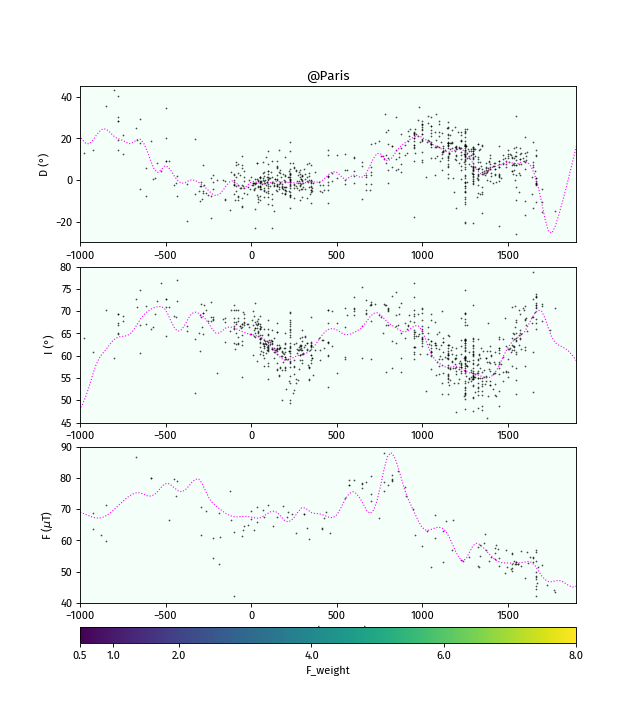

In [33]:
matplotlib.rcParams.update({'font.size': 10})
fig, (ax0, ax1, ax2, ax3) = pyplot.subplots(4,1, figsize=(8,9),
                                           gridspec_kw = {"height_ratios" : [1, 1, 1, 0.10]})

common={"marker" : ".", "s" : 1, "alpha" : 0.8, "color" : "xkcd:black"}
sha_style = {"color" : "xkcd:dark red", "linestyle" : "--", "linewidth" : 2}
rscha_style = {"color" : "xkcd:light red", "alpha" : 0.005}

curve_color = "xkcd:light red"
curve_style = {"linewidth" : 1}
curve_style_2 = {"linewidth" : 1, "linestyle" : ":", "color" : "magenta"}

ax0.set_ylabel("D (°)")
ax1.set_ylabel("I (°)")
ax2.set_ylabel("F ($\mu $T)")
ax0.set_title("@{}".format(name_at))

n_curves = len(curves)
cmap = pyplot.cm.viridis

ax0.scatter(model2.tv[near], numpy.rad2deg(D_reloc)[near], **common)
ax0.plot(t_cur, numpy.rad2deg(curves_spec[0]), **curve_style_2)
ax0.set_ybound(-30, 45)

ax1.scatter(model2.tv[near], numpy.rad2deg(I_reloc)[near], **common)
ax1.plot(t_cur, numpy.rad2deg(curves_spec[1]), **curve_style_2)
ax1.set_ybound(45, 80)

ax2.scatter(model2.tv[near], F_reloc[near], **common)
ax2.plot(t_cur, curves_spec[2], **curve_style_2)
ax2.set_ybound(40, 90)
ax2.set_xlabel("Time (years AD)")
    
for ax in (ax0, ax1, ax2):
    ax.set_xbound(-1000, 1900)
    ax.set_facecolor("mintcream")

cb1 = matplotlib.colorbar.ColorbarBase(ax3, cmap=cmap,
                                norm=matplotlib.colors.Normalize(
                                    vmin=numpy.min(F_weights), vmax=numpy.max(F_weights)),
                                ticks = F_weights,
                                ticklocation="bottom",
                                orientation='horizontal')
ax3.set_xlabel("F_weight")
fig.show()

In [9]:
# usando: pesos igual a 1/datos

import os
import datetime

now = str(datetime.datetime.now())
dirname = f"../data/rscha2d/rscha2d_{now}"
os.mkdir(dirname)

n_iterations = 100
g_boot = numpy.zeros((len(g), n_iterations))
for i in range(n_iterations):
    model2.wiggle()
    g_boot[:, i] = model2.solve(complete=True)["coefs"]
    print(gauge.gauge(i+1, n_iterations), end="\r")

f = open(f"{dirname}/meta.txt", "w")
f.write(model2.export_params())
f.write(f"n_iterations : {n_iterations}\n")
f.close()
numpy.save(f"{dirname}/coefs.npy", g_boot)

In [10]:
#método 1
#usar las g obtenidas para generar las cosas

D_cur_boot = numpy.zeros((len(t_cur), n_iterations))
I_cur_boot = D_cur_boot.copy()
F_cur_boot = D_cur_boot.copy()

for i in range(n_iterations):
    D_cur_boot[:, i], I_cur_boot[:,i], F_cur_boot[:,i] = (
        model2.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_boot[:,i])
    )
    print(gauge.gauge(i+1, n_iterations), end="\r")
    
D_avg = numpy.average(D_cur_boot, axis=1)
I_avg = numpy.average(I_cur_boot, axis=1)
F_avg = numpy.average(F_cur_boot, axis=1)

D_std = numpy.std(D_cur_boot, axis=1)
I_std = numpy.std(I_cur_boot, axis=1)
F_std = numpy.std(F_cur_boot, axis=1)

<IPython.core.display.Javascript object>


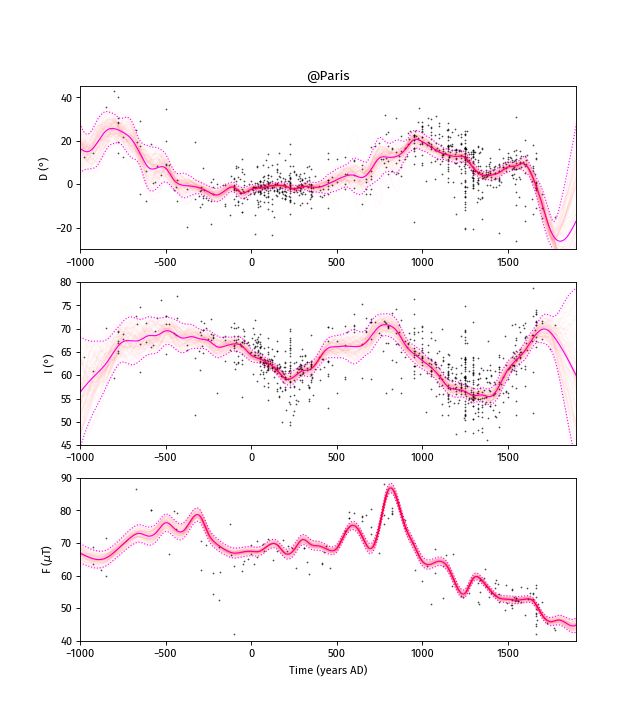

In [29]:
matplotlib.rcParams.update({'font.size': 10})
fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9),
                                       gridspec_kw = {"height_ratios" : [1, 1, 1]})

common={"marker" : ".", "s" : 1, "alpha" : 0.8, "color" : "xkcd:black"}
sha_style = {"color" : "xkcd:dark red", "linestyle" : "--", "linewidth" : 2}
rscha_style = {"color" : "xkcd:light red", "alpha" : 0.005}

curve_color = "xkcd:light red"
curve_style = {"linewidth" : 1}
curve_style_2 = {"linewidth" : 1, "linestyle" : ":", "color" : "magenta"}

ax0.set_ylabel("D (°)")
ax1.set_ylabel("I (°)")
ax2.set_ylabel("F ($\mu $T)")
ax0.set_title("@{}".format(name_at))

n_curves = len(curves)
cmap = pyplot.cm.viridis

ax0.scatter(model2.tv[near], numpy.rad2deg(D_reloc)[near], **common)
ax0.plot(t_cur, numpy.rad2deg(D_avg), **curve_style, color="magenta")
ax0.plot(t_cur, numpy.rad2deg(D_avg + 2*D_std), **curve_style_2)
ax0.plot(t_cur, numpy.rad2deg(D_avg - 2*D_std), **curve_style_2)
for cv in D_cur_boot.T:
    ax0.plot(t_cur, numpy.rad2deg(cv), **curve_style, color="red", alpha=0.02)
ax0.set_ybound(-30, 45)

ax1.scatter(model2.tv[near], numpy.rad2deg(I_reloc)[near], **common)
ax1.plot(t_cur, numpy.rad2deg(I_avg), **curve_style, color="magenta")
ax1.plot(t_cur, numpy.rad2deg(I_avg + 2*I_std), **curve_style_2)
ax1.plot(t_cur, numpy.rad2deg(I_avg - 2*I_std), **curve_style_2)
for cv in I_cur_boot.T:
    ax1.plot(t_cur, numpy.rad2deg(cv), **curve_style, color="red", alpha=0.02)
ax1.set_ybound(45, 80)

ax2.scatter(model2.tv[near], F_reloc[near], **common)
ax2.plot(t_cur, F_avg, **curve_style, color="magenta")
ax2.plot(t_cur, F_avg + 2*F_std, **curve_style_2)
ax2.plot(t_cur, F_avg - 2*F_std, **curve_style_2)
for cv in F_cur_boot.T:
    ax2.plot(t_cur, cv, **curve_style, color="red", alpha=0.02)
ax2.set_ybound(40, 90)
ax2.set_xlabel("Time (years AD)")
    
for ax in (ax0, ax1, ax2):
    ax.set_xbound(-1000, 1900)
    ax.set_facecolor("white")

fig.show()

In [27]:
constants.min_Ferr

2.0

In [ ]:
# it's bad